In [ ]:
%pip install python-dotenv
%pip install langchain-pinecone langchain-openai langchain-community
%pip install langgraph
%pip install langgraph_supervisor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.3/524.3 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 k

In [ ]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")
_set_env("PINECONE_API_KEY")
_set_env("PINECONE_ENVIRONMENT")

OPENAI_API_KEY:··········
PINECONE_API_KEY:··········
PINECONE_ENVIRONMENT:··········


In [ ]:
from dotenv import load_dotenv

load_dotenv()

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import ReadTheDocsLoader
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
loader = ReadTheDocsLoader("https://www.edubull.com/Content/eRepository/SubjectContent/Notes/3634.pdf")
raw_documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=50)
documents = text_splitter.split_documents(raw_documents)
for doc in documents:
    new_url = doc.metadata["source"]
    doc.metadata.update({"source": new_url})
retriever = PineconeVectorStore.from_documents(
    documents, embeddings, index_name="project2"
).as_retriever()


In [ ]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    name="search_docs",
    description="Search the knowledge base."
)

In [ ]:
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI

response_model = ChatOpenAI(model="gpt-4o", temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [ ]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [ ]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "How was cricket spread in India?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_docs (call_hvavEPiTFuZTQ6MutGTHFOUR)
 Call ID: call_hvavEPiTFuZTQ6MutGTHFOUR
  Args:
    query: spread of cricket in India


In [ ]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_openai import ChatOpenAI

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "Instructions:\n"
    "- Return 'yes' if the document clearly answers the question.\n"
    "- If the document touches the topic or answers part of the question, return 'partially relevant'.\n"
    "- If the document does not answer the question at all, return 'no'.\n"
    "Return only one of these values exactly: 'yes', 'partially relevant', or 'no'. Do not include explanations."

)
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""
    binary_score: Literal["yes", "partially relevant", "no"] = Field(
        description="Relevance score: 'yes' if clearly relevant, 'partially relevant' if loosely related, 'no' if unrelated"
    )
grader_model = ChatOpenAI(model="gpt-4o", temperature=0)

def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question","ignore_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "should_generate_answer"
    elif score == "partially relevant":
        return "should_rewrite_question"
    else:
      return "should_ignore_question"

In [ ]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

In [ ]:
from langchain_core.messages import BaseMessage
from typing import List
def ignore_question(state: MessagesState):
    """Ignore user question, if the document is not relevant at all."""
    question = messages[0].content
    context = messages[-1].content
    prompt = IGNORE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}
ignore_question_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[ignore_question],
    prompt=(
        "You are a ignore_question agent.\n\n"
        "Here is the initial question: {question}\n\n"
        "Here is the document: {context}\n\n"
        "If the document is not at all related to the question, respond with:\n"
        "'The question is not related to the document provided.'\n"
        "INSTRUCTIONS:\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="ignore_question_agent",
)

In [ ]:
from langchain_core.messages import BaseMessage
from typing import List

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    question = messages[0].content
    context = messages[-1].content
    prompt = REWRITE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}
rewrite_question_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[rewrite_question],
    prompt=(
        "You are a rewrite_question agent.\n\n"
        "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
        "Here is the initial question: {question}\n"
        "Here is the document: {context}\n"
        "INSTRUCTIONS:\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="rewrite_question_agent",
)

In [ ]:
def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}
generate_answer_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[rewrite_question],
    prompt=(
        "You are a generate_answer agent.\n\n"
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer the question. "
        "Use three sentences maximum and keep the answer concise.\n"
        "Here is the initial question: {question}\n"
        "Here is the document: {context}\n"
        "INSTRUCTIONS:\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="generate_answer_agent",
)

In [ ]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI

response_model = ChatOpenAI(model="gpt-4o", temperature=0)


supervisor = create_supervisor(
    model=response_model,
    agents=[ignore_question_agent,rewrite_question_agent,generate_answer_agent],
    prompt=(
        "You are a supervisor managing three agents:\n"
        "- a generate_answer agent. Returns answers for questions related to the document.\n"
        "- a ignore_question agent. Returns 'Not related' for questions completely irrelevant to the document.\n"
        "- an rewrite_question agent. Rewrites the question atmost 3 times before generating an answer to a question that is relevant to the document.\n"
        "INSTRUCTIONS:\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

In [ ]:
for chunk in ignore_question_agent.stream(
    {"messages": [{"role": "user", "content": "Capital of Karnataka"}]}
):
    print(chunk)


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xjkqe3hky1pIhjewennZb4cG', 'function': {'arguments': '{"state":{"messages":[{"content":"Capital of Karnataka","type":"human"}]}}', 'name': 'ignore_question'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 3070, 'total_tokens': 3097, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BmwgEnwyrfq1BXxAwiOxFdp0YwsEb', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='ignore_question_agent', id='run--8895afa0-992e-40f1-a438-a0cf549b4345-0', tool_calls=[{'name': 'ignore_question', 'args': {'state': {'messages': [{'content': 'Capital of Karnataka', 'type': '

In [ ]:
for chunk in rewrite_question_agent.stream(
    {"messages": [{"role": "user", "content": "How many members play in a cricket team?"}]}
):
    print(chunk)


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rU4oCSWHn6LOYOr5fhBjPsdc', 'function': {'arguments': '{"state":{"messages":[{"content":"How many members play in a cricket team?","type":"human"}]}}', 'name': 'rewrite_question'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 3059, 'total_tokens': 3093, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-Bmwh5yjjnAlod4gMyBS9gkSk7BL1P', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='rewrite_question_agent', id='run--874a013a-97f7-43d4-8840-6ad9c636e9b7-0', tool_calls=[{'name': 'rewrite_question', 'args': {'state': {'messages': [{'content': 'How many 

In [ ]:
for chunk in generate_answer_agent.stream(
    {"messages": [{"role": "user", "content": "events that contributed to the spread of cricket in India?"}]}
):
    print(chunk)


{'agent': {'messages': [AIMessage(content='The spread of cricket in India was initiated by British colonial rule, with the first recorded match played in the early 18th century. The establishment of cricket clubs by British settlers and the participation of local communities, such as the Parsis in Bombay, further popularized the game. Major events like the formation of the Bombay Quadrangular tournament and India’s eventual participation in international cricket strengthened cricket’s presence and appeal throughout the country.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 3077, 'total_tokens': 3163, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BmwiwtFJq9l9UUNrlMwvp16vL

In [ ]:
for chunk in generate_answer_agent.stream(
    {"messages": [{"role": "user", "content": "The origins of Indian cricket, that is, cricket played by Indians are to be found in Bombay."}]}
):
    print(chunk)


{'agent': {'messages': [AIMessage(content='The origins of Indian cricket, specifically cricket played by Indians, can be traced back to Bombay.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 3086, 'total_tokens': 3106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-Bmwk3Bl5exE238rsHY2W76XxsCWF7', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='generate_answer_agent', id='run--641bfd79-d0e3-4b7e-9432-ff45a5000f4c-0', usage_metadata={'input_tokens': 3086, 'output_tokens': 20, 'total_tokens': 3106, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


In [ ]:
def pretty_print_messages(chunk, last_message=False):
    if last_message:
        messages = chunk.get("supervisor", {}).get("messages", [])
    else:
        messages = chunk.get("messages", [])

    for message in messages:
        print(f"{message.role}: {message.content}")


In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Capital of Karnataka?How many members play in a cricket team?events that contributed to the spread of cricket in India?The origins of Indian cricket, that is, cricket played by Indians are to be found in Bombay.",
            }
        ]
    },
):
    print(chunk)

final_message_history = chunk["supervisor"]["messages"]


{'supervisor': {'messages': [HumanMessage(content='Capital of Karnataka?How many members play in a cricket team?events that contributed to the spread of cricket in India?The origins of Indian cricket, that is, cricket played by Indians are to be found in Bombay.', additional_kwargs={}, response_metadata={}, id='e1efb7be-33b1-499b-b2e9-c4a609f8e2fa'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Qs6pikjoj5DK6nEuzEpcaqs2', 'function': {'arguments': '{}', 'name': 'transfer_to_ignore_question_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 228, 'total_tokens': 241, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bmwlt6bybfe7dnMVpOGL7RkXgcs6E', 's

In [ ]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

Capital of Karnataka?How many members play in a cricket team?events that contributed to the spread of cricket in India?The origins of Indian cricket, that is, cricket played by Indians are to be found in Bombay.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_ignore_question_agent (call_Qs6pikjoj5DK6nEuzEpcaqs2)
 Call ID: call_Qs6pikjoj5DK6nEuzEpcaqs2
  Args:
================================= Tool Message =================================
Name: transfer_to_ignore_question_agent

Successfully transferred to ignore_question_agent
================================== Ai Message ==================================
Name: ignore_question_agent

The question is not related to the document provided.
================================== Ai Message ==================================
Name: ignore_question_agent

Transferring back to supervisor
To

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "events that contributed to the spread of cricket in India?.",
            }
        ]
    },
):
    print(chunk)

final_message_history = chunk["supervisor"]["messages"]


{'supervisor': {'messages': [HumanMessage(content='events that contributed to the spread of cricket in India?.', additional_kwargs={}, response_metadata={}, id='dc12b23c-d345-4b77-94e6-a7a29a0584cc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0RgJ3G5o7l7XgRGjKHfYiFgL', 'function': {'arguments': '{}', 'name': 'transfer_to_generate_answer_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 195, 'total_tokens': 208, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BmwrlMfmb5kj9zAtYfqsfBrAdIXvC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--228121eb-5136-428e-ab50-ab0d2054d827-0', tool_cal

In [ ]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

events that contributed to the spread of cricket in India?.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_generate_answer_agent (call_0RgJ3G5o7l7XgRGjKHfYiFgL)
 Call ID: call_0RgJ3G5o7l7XgRGjKHfYiFgL
  Args:
================================= Tool Message =================================
Name: transfer_to_generate_answer_agent

Successfully transferred to generate_answer_agent
================================== Ai Message ==================================
Name: generate_answer_agent

The spread of cricket in India was influenced by several key events: the introduction of the game by British colonial rulers in the 18th century, the formation of local cricket clubs like the Bombay Gymkhana and the Parsi Cricket Club, and the hosting of international matches such as the first test match in 1932. Cricket became deeply embedded in I

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Role of women in cricket",
            }
        ]
    },
):
    print(chunk)

final_message_history = chunk["supervisor"]["messages"]


{'supervisor': {'messages': [HumanMessage(content='Role of women in cricket', additional_kwargs={}, response_metadata={}, id='1ad54e54-b48e-4476-bfd4-af403387759f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yynTSdk0imznuYdPx0VRxJLI', 'function': {'arguments': '{}', 'name': 'transfer_to_generate_answer_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 189, 'total_tokens': 202, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BmwsAUIMqoo0hWiw4SXtpoepaeLzy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--2c61d686-8055-4af2-aa94-c14ff747cee3-0', tool_calls=[{'name': 'transfer_to_generate_

In [ ]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

Role of women in cricket
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_generate_answer_agent (call_yynTSdk0imznuYdPx0VRxJLI)
 Call ID: call_yynTSdk0imznuYdPx0VRxJLI
  Args:
================================= Tool Message =================================
Name: transfer_to_generate_answer_agent

Successfully transferred to generate_answer_agent
================================== Ai Message ==================================
Name: generate_answer_agent

Women have played an increasingly significant role in cricket, both as players and leaders. Women's cricket has grown globally, with international tournaments, professional leagues, and greater media coverage. Female cricketers have become role models, advocating for gender equality and inspiring participation at all levels of the sport.
================================== Ai Message

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Evolution of cricket in India",
            }
        ]
    },
):
    print(chunk)

final_message_history = chunk["supervisor"]["messages"]


{'supervisor': {'messages': [HumanMessage(content='Evolution of cricket in India', additional_kwargs={}, response_metadata={}, id='a7a83024-e515-4902-92b6-c8a2b365f391'), AIMessage(content='Please provide a specific question related to the topic "Evolution of cricket in India" so that I can assist you better.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 189, 'total_tokens': 214, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BmwtNcaWjGM1Fg045yFXWYmaVnl3U', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='supervisor', id='run--ab8c9163-b8ed-4d35-8df5-0a31778a0eda-0', usage_metadata={'input_tokens': 189, 'output_tokens': 25, 'total_tokens': 214, 

In [ ]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

Evolution of cricket in India
================================== Ai Message ==================================
Name: supervisor

Please provide a specific question related to the topic "Evolution of cricket in India" so that I can assist you better.


In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "The origins of Indian cricket, that is, cricket played by Indians are to be found in Bombay.",
            }
        ]
    },
):
    print(chunk)

final_message_history = chunk["supervisor"]["messages"]


{'supervisor': {'messages': [HumanMessage(content='The origins of Indian cricket, that is, cricket played by Indians are to be found in Bombay.', additional_kwargs={}, response_metadata={}, id='98062600-8c4a-4971-978e-2fc3ba37ef41'), AIMessage(content='What would you like to know about the origins of Indian cricket?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 204, 'total_tokens': 218, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BmwuEBOCi0OWqCR0RztBMdQGbUlCP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='supervisor', id='run--fb95d560-53cc-417e-b52e-31c535613cd6-0', usage_metadata={'input_tokens': 204, 'output_tokens': 14, 'total_tokens'

In [ ]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

The origins of Indian cricket, that is, cricket played by Indians are to be found in Bombay.
================================== Ai Message ==================================
Name: supervisor

What would you like to know about the origins of Indian cricket?


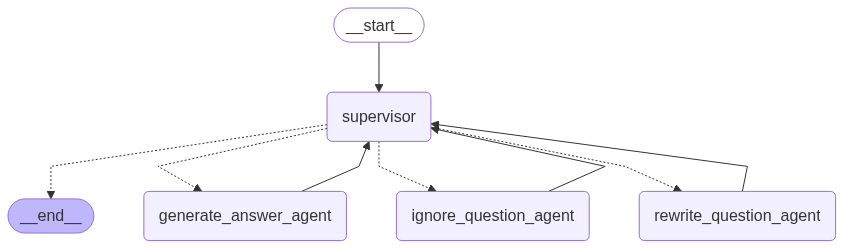

In [ ]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
workflow = StateGraph(MessagesState)
workflow.add_node(generate_query_or_respond)
workflow.add_node("supervisor", supervisor)
workflow.add_node("retrieve", retriever_tool)
workflow.add_node("rewrite_question", rewrite_question)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("ignore_question", ignore_question)
workflow.add_edge(START, "generate_query_or_respond")
workflow.add_edge("generate_query_or_respond","supervisor")
workflow.add_edge("supervisor", "retrieve")
workflow.add_edge("supervisor", "retrieve")
workflow.add_edge("retrieve", "rewrite_question")
workflow.add_edge("retrieve", "generate_answer")
workflow.add_edge("supervisor", "ignore_question")
workflow.add_edge("rewrite_question","supervisor")
workflow.add_edge("generate_answer", "supervisor")
workflow.add_edge("ignore_question","supervisor")
workflow.add_edge("rewrite_question", "generate_query_or_respond")
workflow.add_edge("generate_answer", END)
workflow.add_edge("ignore_question", END)
workflow.add_edge("supervisor", END)
graph = workflow.compile()


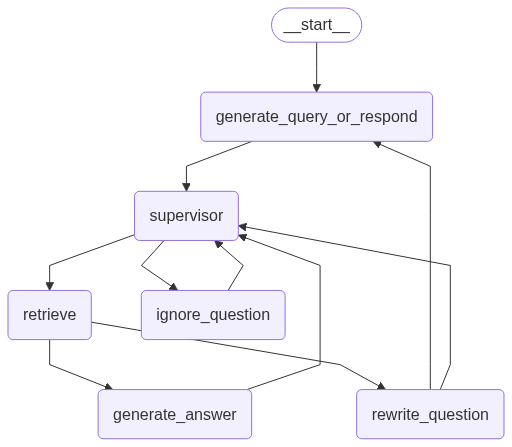

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Where is Tamil Nadu? What was Mahatma Gandhi's opinion on cricket?",
            }
        ]
    },
):
    print(chunk)

final_message_history = chunk["supervisor"]["messages"]


{'supervisor': {'messages': [HumanMessage(content="Where is Tamil Nadu? What was Mahatma Gandhi's opinion on cricket?", additional_kwargs={}, response_metadata={}, id='4fe2f886-c243-49ae-a80a-e94eb0ce74be'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EtjwAdHytMk7cyEhX0xGD9Ou', 'function': {'arguments': '{}', 'name': 'transfer_to_ignore_question_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 199, 'total_tokens': 212, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BmxKKrtO6zpigcoegyPoysFpfPRGy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--dcf4aa3a-5149-4da5-8f94-4edb6615b1dc-0', t

In [ ]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

Where is Tamil Nadu? What was Mahatma Gandhi's opinion on cricket?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_ignore_question_agent (call_EtjwAdHytMk7cyEhX0xGD9Ou)
 Call ID: call_EtjwAdHytMk7cyEhX0xGD9Ou
  Args:
================================= Tool Message =================================
Name: transfer_to_ignore_question_agent

Successfully transferred to ignore_question_agent
================================== Ai Message ==================================
Name: ignore_question_agent

The question is not related to the document provided.
================================== Ai Message ==================================
Name: ignore_question_agent

Transferring back to supervisor
Tool Calls:
  transfer_back_to_supervisor (c0a7b5c1-3af1-492f-a60c-104ec23d5e80)
 Call ID: c0a7b5c1-3af1-492f-a60c-104ec23d5e80
  Args:
===========

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Where is Tamil Nadu? Events that led to the spread of cricket?",
            }
        ]
    },
):
    print(chunk)

final_message_history = chunk["supervisor"]["messages"]


{'supervisor': {'messages': [HumanMessage(content='Where is Tamil Nadu? Events that led to the spread of cricket?', additional_kwargs={}, response_metadata={}, id='deac6ee9-c654-4147-aedc-2a4e5194d7c6'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_x7zHdJq1R3PoStBnWMsz4egu', 'function': {'arguments': '{}', 'name': 'transfer_to_ignore_question_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 198, 'total_tokens': 211, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BmxLPeBucu9NnCAxcp5mML3xaySyU', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--7a122e05-7f65-400f-8cf4-19600d4ebb8c-0', tool_

In [ ]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

Where is Tamil Nadu? Events that led to the spread of cricket?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_ignore_question_agent (call_x7zHdJq1R3PoStBnWMsz4egu)
 Call ID: call_x7zHdJq1R3PoStBnWMsz4egu
  Args:
================================= Tool Message =================================
Name: transfer_to_ignore_question_agent

Successfully transferred to ignore_question_agent
================================== Ai Message ==================================
Name: ignore_question_agent

The question is not related to the document provided.
================================== Ai Message ==================================
Name: ignore_question_agent

Transferring back to supervisor
Tool Calls:
  transfer_back_to_supervisor (e13fc7b2-5d37-4bbe-a8eb-f989e886942b)
 Call ID: e13fc7b2-5d37-4bbe-a8eb-f989e886942b
  Args:
===============

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Where is Tamil Nadu? Role of women in cricket",
            }
        ]
    },
):
    print(chunk)

final_message_history = chunk["supervisor"]["messages"]


{'supervisor': {'messages': [HumanMessage(content='Where is Tamil Nadu? Role of women in cricket', additional_kwargs={}, response_metadata={}, id='0f43e33c-0223-4e6c-8b69-dc508d2c3504'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bL8eHLn0hSfw1d5yYizeN1Lu', 'function': {'arguments': '{}', 'name': 'transfer_to_ignore_question_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 194, 'total_tokens': 207, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BmxMX9RpZrnutzwj1o8hyPepPKVQs', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--2b83a554-0d0c-4b63-86d2-12a8437f3834-0', tool_calls=[{'name': '

In [ ]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

Where is Tamil Nadu? Role of women in cricket
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_ignore_question_agent (call_bL8eHLn0hSfw1d5yYizeN1Lu)
 Call ID: call_bL8eHLn0hSfw1d5yYizeN1Lu
  Args:
================================= Tool Message =================================
Name: transfer_to_ignore_question_agent

Successfully transferred to ignore_question_agent
================================== Ai Message ==================================
Name: ignore_question_agent

The question is not related to the document provided.
================================== Ai Message ==================================
Name: ignore_question_agent

Transferring back to supervisor
Tool Calls:
  transfer_back_to_supervisor (8a2c55af-953d-4ca8-b15f-09d01b6d34fb)
 Call ID: 8a2c55af-953d-4ca8-b15f-09d01b6d34fb
  Args:
================================

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "How was cricket spread around the world?",
            }
        ]
    },
):
    print(chunk)

final_message_history = chunk["supervisor"]["messages"]


{'supervisor': {'messages': [HumanMessage(content='How was cricket spread arounf the world?', additional_kwargs={}, response_metadata={}, id='b9109e70-a48d-45dc-b5b0-46361a2cd0d2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KFgQGnzYKle5qHJVeahyVGlj', 'function': {'arguments': '{}', 'name': 'transfer_to_ignore_question_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 194, 'total_tokens': 207, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BmzqFfTluGy0sbj0f1unu8Ala0aSL', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--e21c4724-e247-4b4c-9d6c-66ac2e355f70-0', tool_calls=[{'name': 'trans